In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import deepgraph as dg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from graph_tool.all import *
import random

%matplotlib inline 

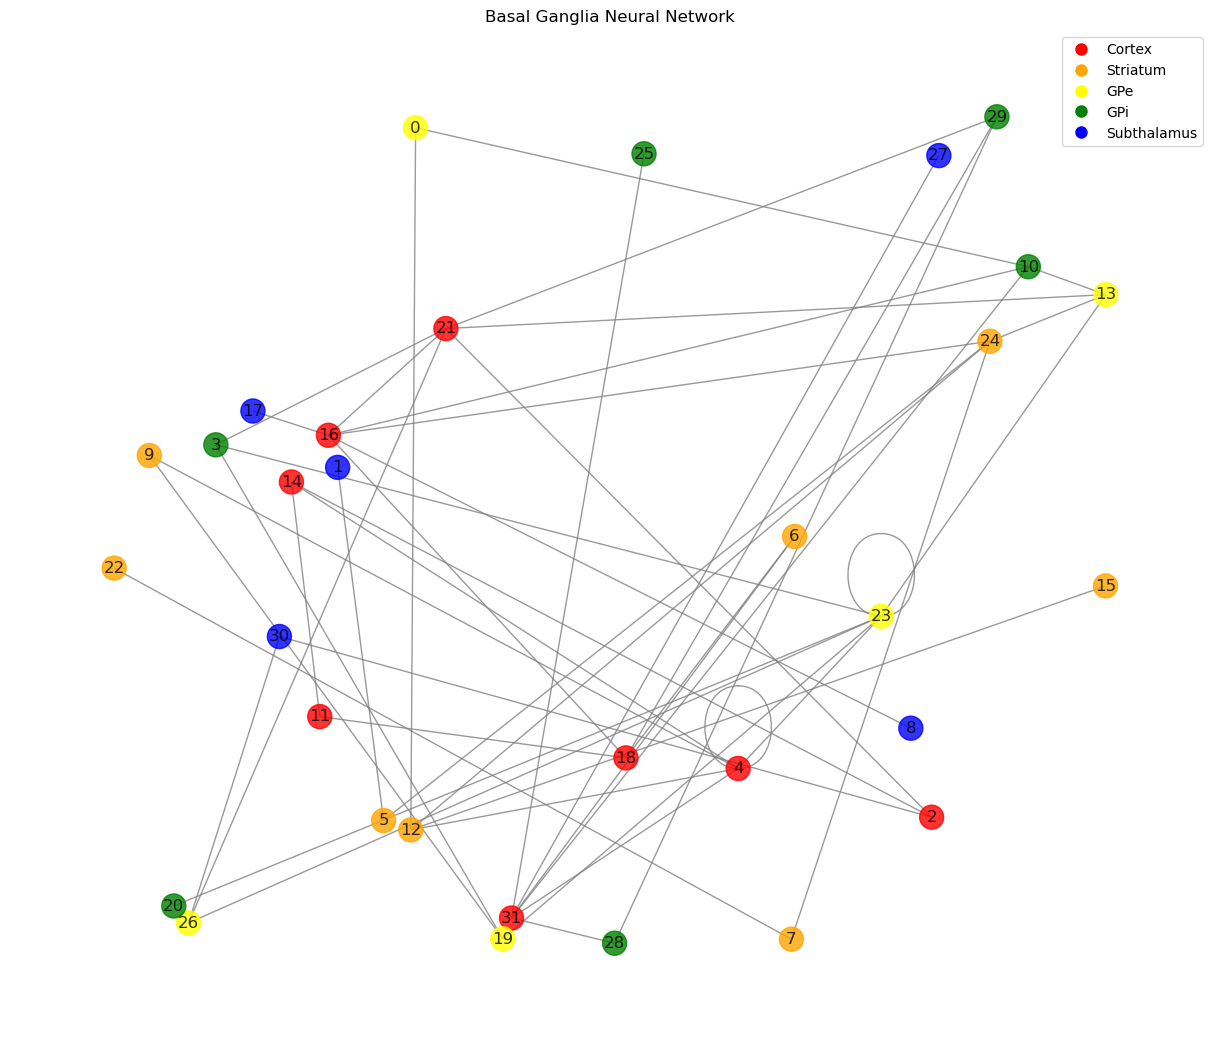

In [16]:
# Create a DataFrame with neurons (nodes)
neurons = pd.DataFrame({
    'structure': ['Cortex']*10 + ['Striatum']*8 + ['GPe']*6 + ['GPi']*6 + ['Subthalamus']*5,
    'neuron_id': list(range(35))
})

# Add x and y positions for plotting purposes
np.random.seed(35)
neurons['x'] = np.random.rand(len(neurons)) * 100
neurons['y'] = np.random.rand(len(neurons)) * 100

# Define connections (edges) between neurons
edges = pd.DataFrame({
    'source': np.random.choice(neurons.index, 50),
    'target': np.random.choice(neurons.index, 50),
})

# Filter neurons that are actually used in edges
used_neurons = list(set(edges['source']).union(set(edges['target'])))
neurons = neurons.loc[neurons.index.isin(used_neurons)].reset_index(drop=True)  

# Update neuron IDs to match filtered DataFrame
neurons['neuron_id'] = range(len(neurons))

# Create a new mapping from old to new neuron IDs
id_map = {old_id: new_id for new_id, old_id in enumerate(used_neurons)}
edges.replace({'source': id_map, 'target': id_map}, inplace=True)

# Create positions for the filtered neurons
pos = {i: (neurons.loc[i, 'x'], neurons.loc[i, 'y']) for i in neurons.index}

# Map each structure to a color
structure_colors = {
    'Cortex': 'red',
    'Striatum': 'orange',
    'GPe': 'yellow',
    'GPi': 'green',
    'Subthalamus': 'blue'
}
node_colors = [structure_colors[structure] for structure in neurons['structure']]

# Draw the graph with colored nodes
plt.figure(figsize=(12, 10))
G = nx.from_pandas_edgelist(edges, 'source', 'target')
nx.draw(G, pos, with_labels=True, node_color=node_colors, 
        node_size=300, alpha=0.8, edge_color='gray')

# Add legend manually
legend_elements = [Line2D([0], [0], marker='o', color='w', label=structure, 
                          markerfacecolor=color, markersize=10)
                   for structure, color in structure_colors.items()]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Basal Ganglia Neural Network')
plt.show()


/opt/anaconda3/envs/brain/lib/python3.9/site-packages/graph_tool/draw/cairo_draw.py:681: UserWarning: Unknown parameter: ax
  warnings.warn("Unknown parameter: " + k, UserWarning)


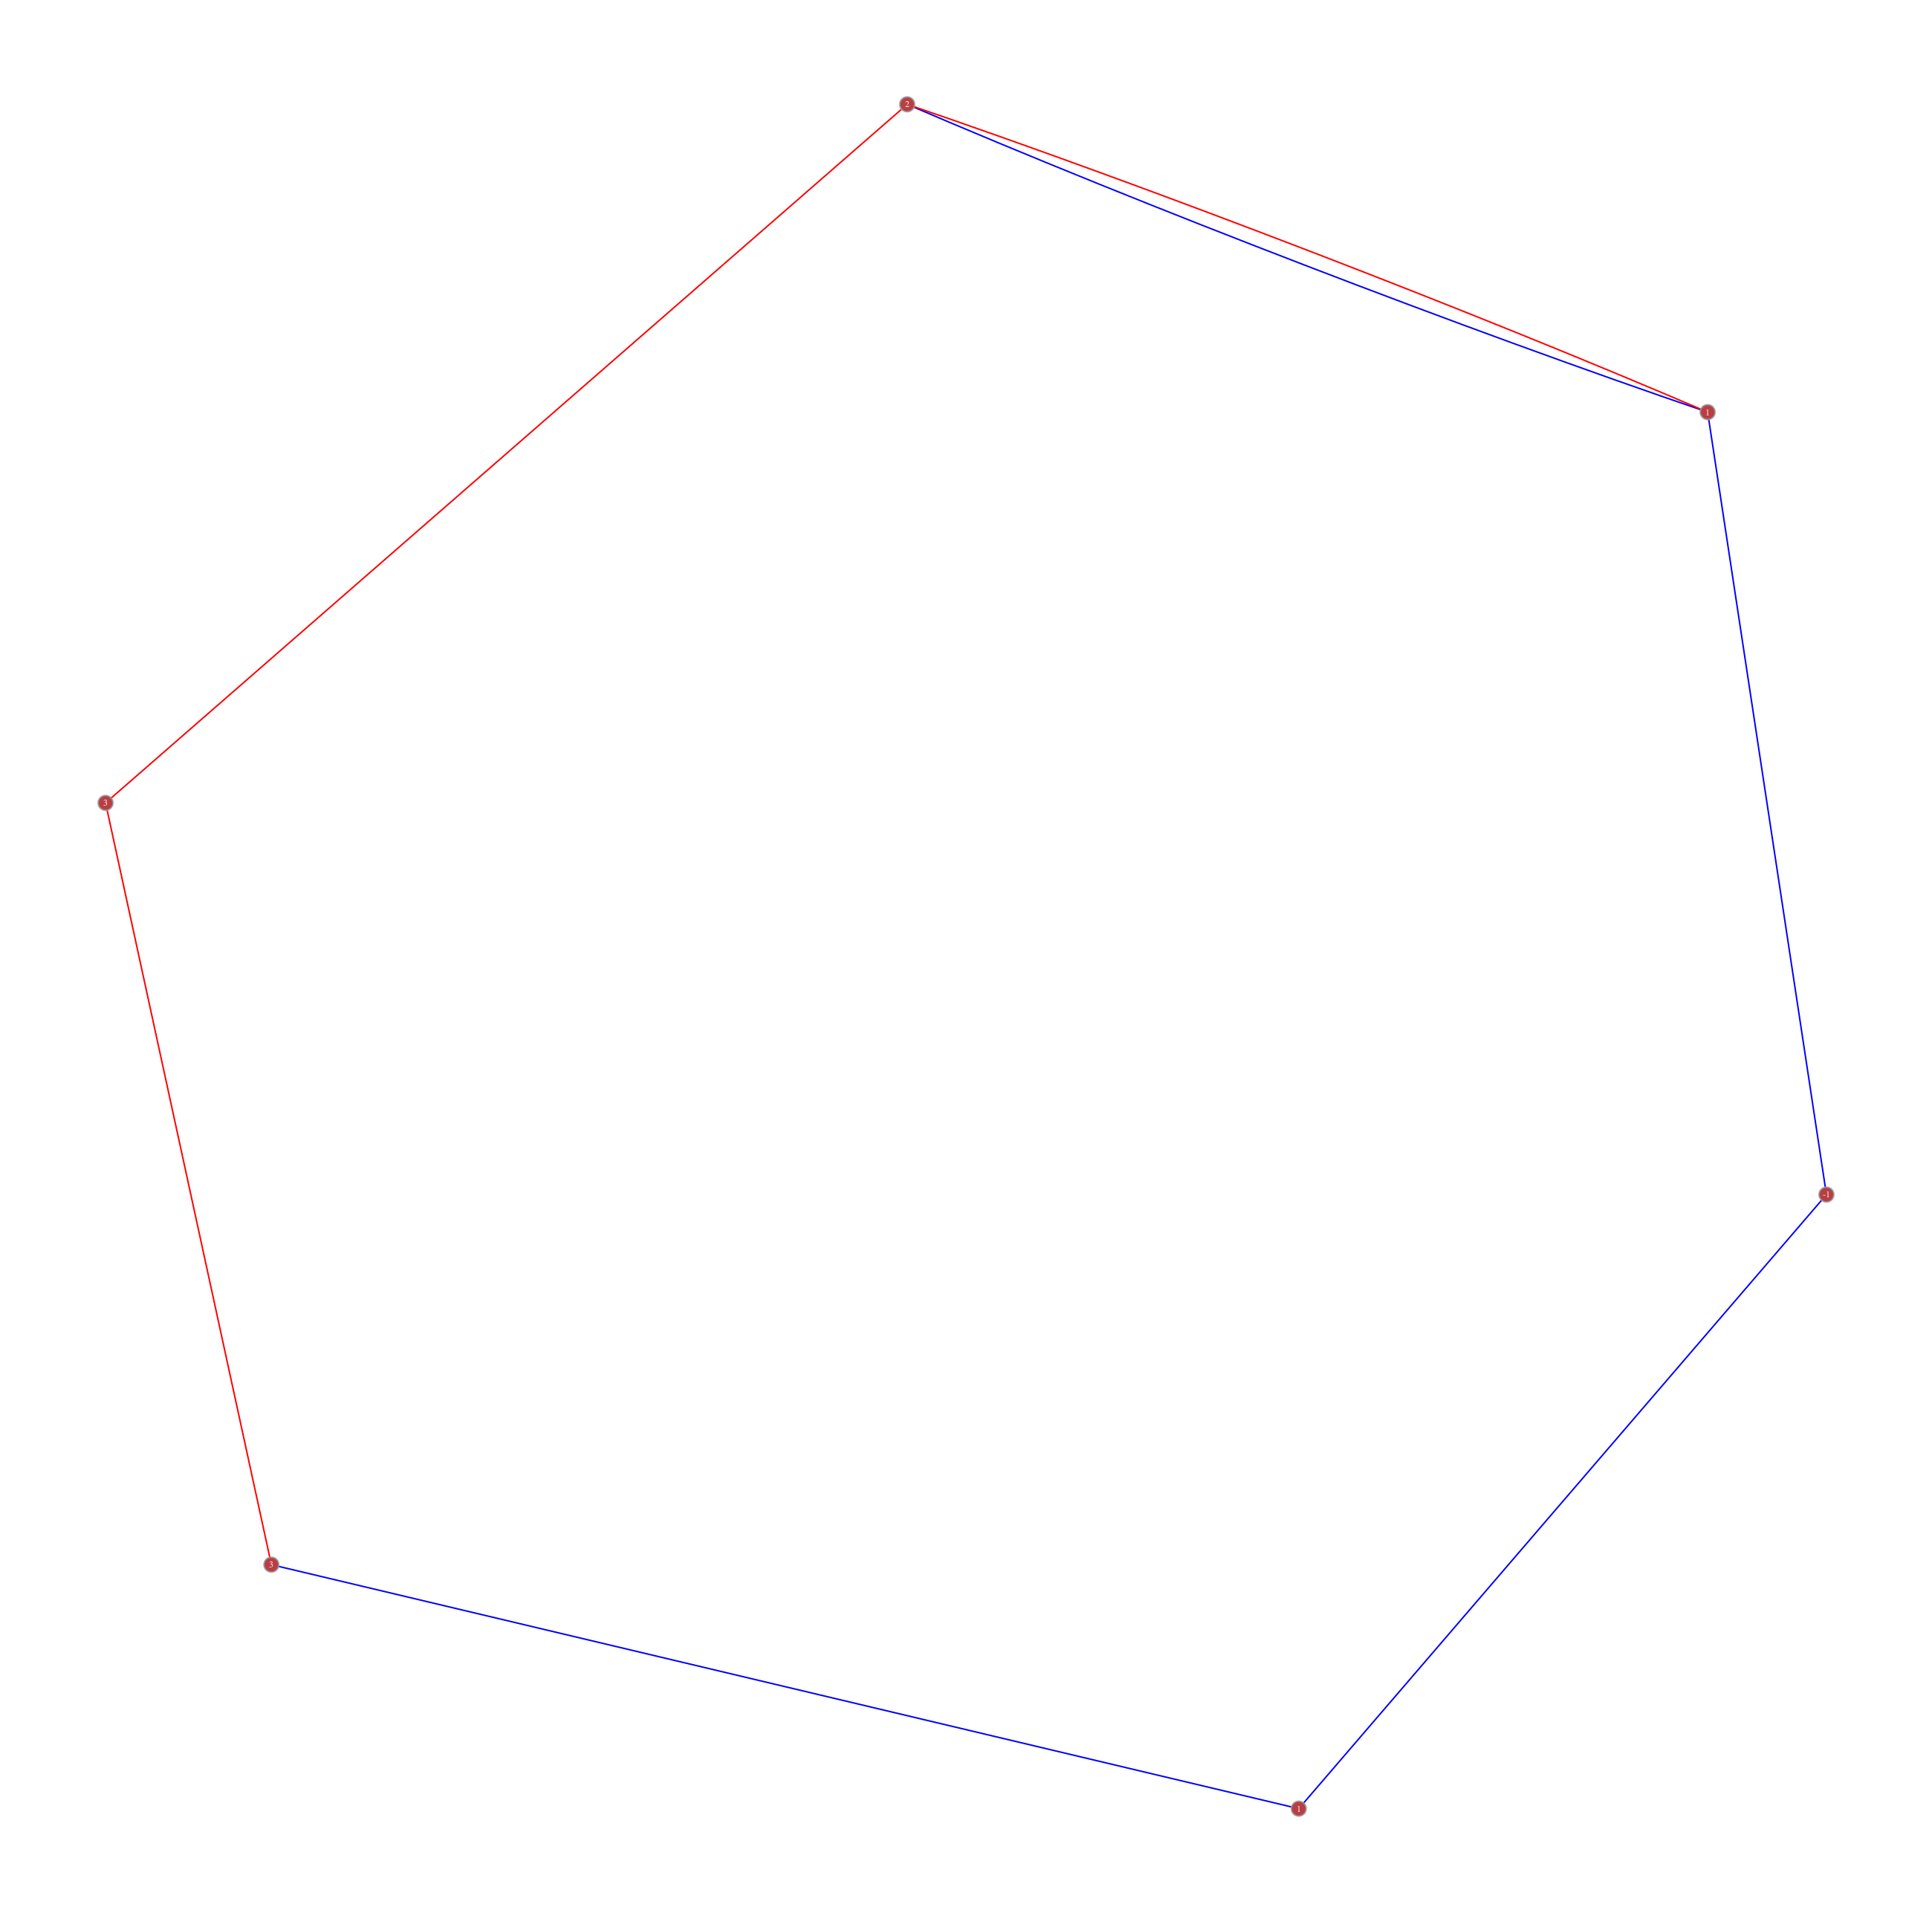

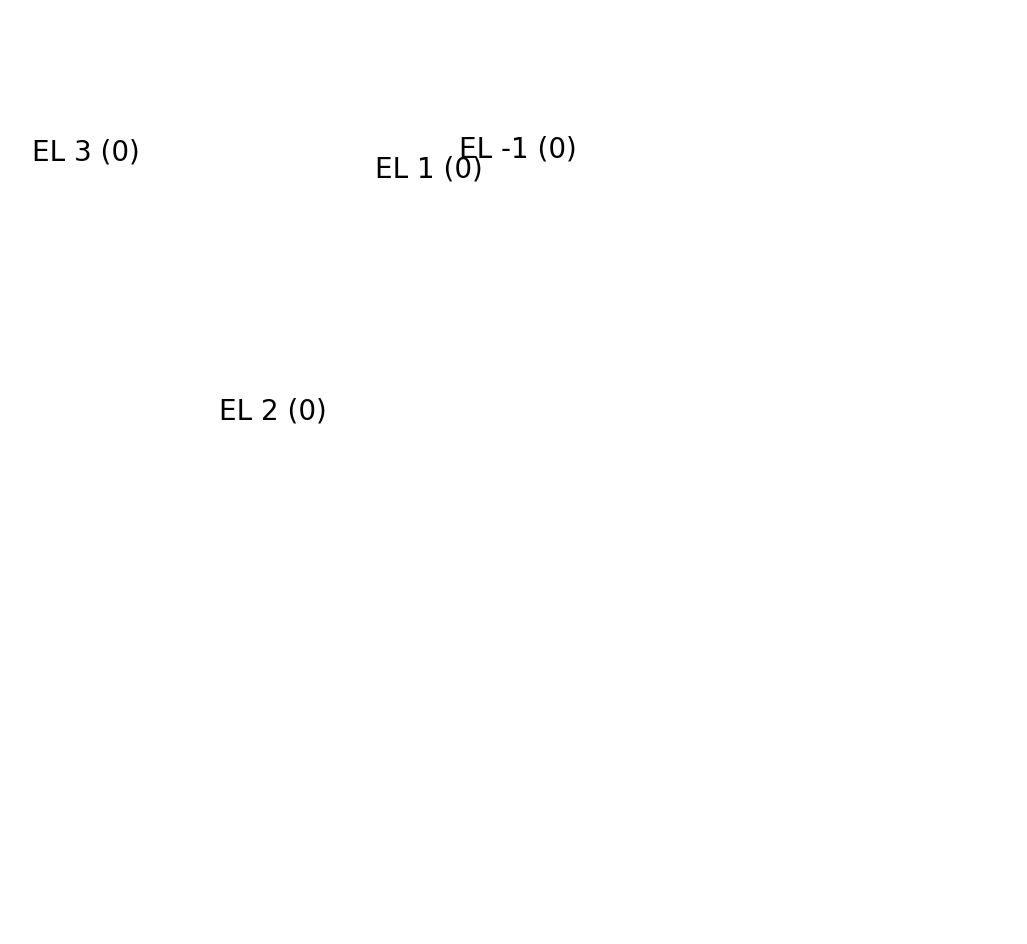

In [1]:
data = {'source': ['STN', 'GPe', 'Cortex', 'Cortex', 'MSN_D1', 'MSN_D2', 'STN'],
        'target': ['GPe', 'STN', 'MSN_D1', 'MSN_D2', 'SNr', 'GPe', 'SNr'],
        'type': ['Excitatory', 'Inhibitory', 'Excitatory', 'Inhibitory', 'Excitatory', 'Inhibitory', 'Excitatory'],
        'Education Level': [1, 2, 3, 2, 1, 3, 2]}  

neuron_counts = {
    'STN': 10,
    'GPe': 5,
    'Cortex': 8,
    'MSN_D1': 30,
    'MSN_D2': 20,
    'SNr': 15
}

df = pd.DataFrame(data)

# GraphTool (no direction)
g = Graph(directed=False)  

# set node
node_map = {} 
for neuron in pd.concat([df['source'], df['target']]).unique():
    v = g.add_vertex()
    node_map[neuron] = v

# set edge
for _, row in df.iterrows():
    src = node_map[row['source']]
    tgt = node_map[row['target']]
    g.add_edge(src, tgt)

# set Education Level 
education_level = g.new_vertex_property("int")

for v in g.vertices():
    neuron_name = list(node_map.keys())[int(v)]  
    if not df[df['source'] == neuron_name].empty:  
        education_level[v] = df[df['source'] == neuron_name]['Education Level'].iloc[0]
    else:
        education_level[v] = -1 

g.vp['Education Level'] = education_level

reverse_node_map = {v: k for k, v in node_map.items()}
C = [df.loc[(df['source'] == reverse_node_map[src]) & (df['target'] == reverse_node_map[tgt]), 'type'].iloc[0] for src, tgt in g.edges()]

pos = sfdp_layout(g, groups=g.vp['Education Level'], mu=.3, gamma=.1)
pos_array = pos.get_2d_array([0, 1])

# PropertyMap transform
pos_map = g.new_vertex_property("vector<double>") 
for v in g.vertices():
    pos_map[v] = [pos_array[0][int(v)], pos_array[1][int(v)]]  

g.vp['x'] = g.new_vertex_property("double") 
g.vp['y'] = g.new_vertex_property("double")

for v in g.vertices():
    g.vp['x'][v] = pos_array[0][int(v)]  
    g.vp['y'][v] = pos_array[1][int(v)]  

color_map = {'Excitatory': 'blue', 'Inhibitory': 'red'} 
edge_color_map = g.new_edge_property("string") 
for i, edge in enumerate(g.edges()):
    edge_color_map[edge] = color_map[C[i]]  

education_level_map = g.new_vertex_property("string") 
for v in g.vertices():
    education_level_map[v] = str(g.vp['Education Level'][v])  

# visualization
fig, ax = plt.subplots(figsize=(13, 12))

graph_draw(g, pos_map, vertex_text=education_level_map, vertex_size=10, edge_color=edge_color_map, output_size=(1300, 1200), ax=ax)

ax.axis('off')

x_values = np.array([g.vp['x'][v] for v in g.vertices()])
y_values = np.array([g.vp['y'][v] for v in g.vertices()])

ax.set_xlim((x_values.min() - 1, x_values.max() + 1))
ax.set_ylim((y_values.min() - 1, y_values.max() + 1))

education_levels = np.unique([g.vp['Education Level'][v] for v in g.vertices()])  # unique()를 numpy로 대체
for el in education_levels:
    vertices_of_level = [v for v in g.vertices() if g.vp['Education Level'][v] == el]
    avg_x = np.mean([g.vp['x'][v] for v in vertices_of_level])
    avg_y = np.mean([g.vp['y'][v] for v in vertices_of_level])
    
    neuron_count = neuron_counts.get(el, 0)
    neuron_name = f'EL {el} ({neuron_count})'  
    ax.text(avg_x - 1, avg_y + 1, neuron_name, fontsize=20)

plt.show()


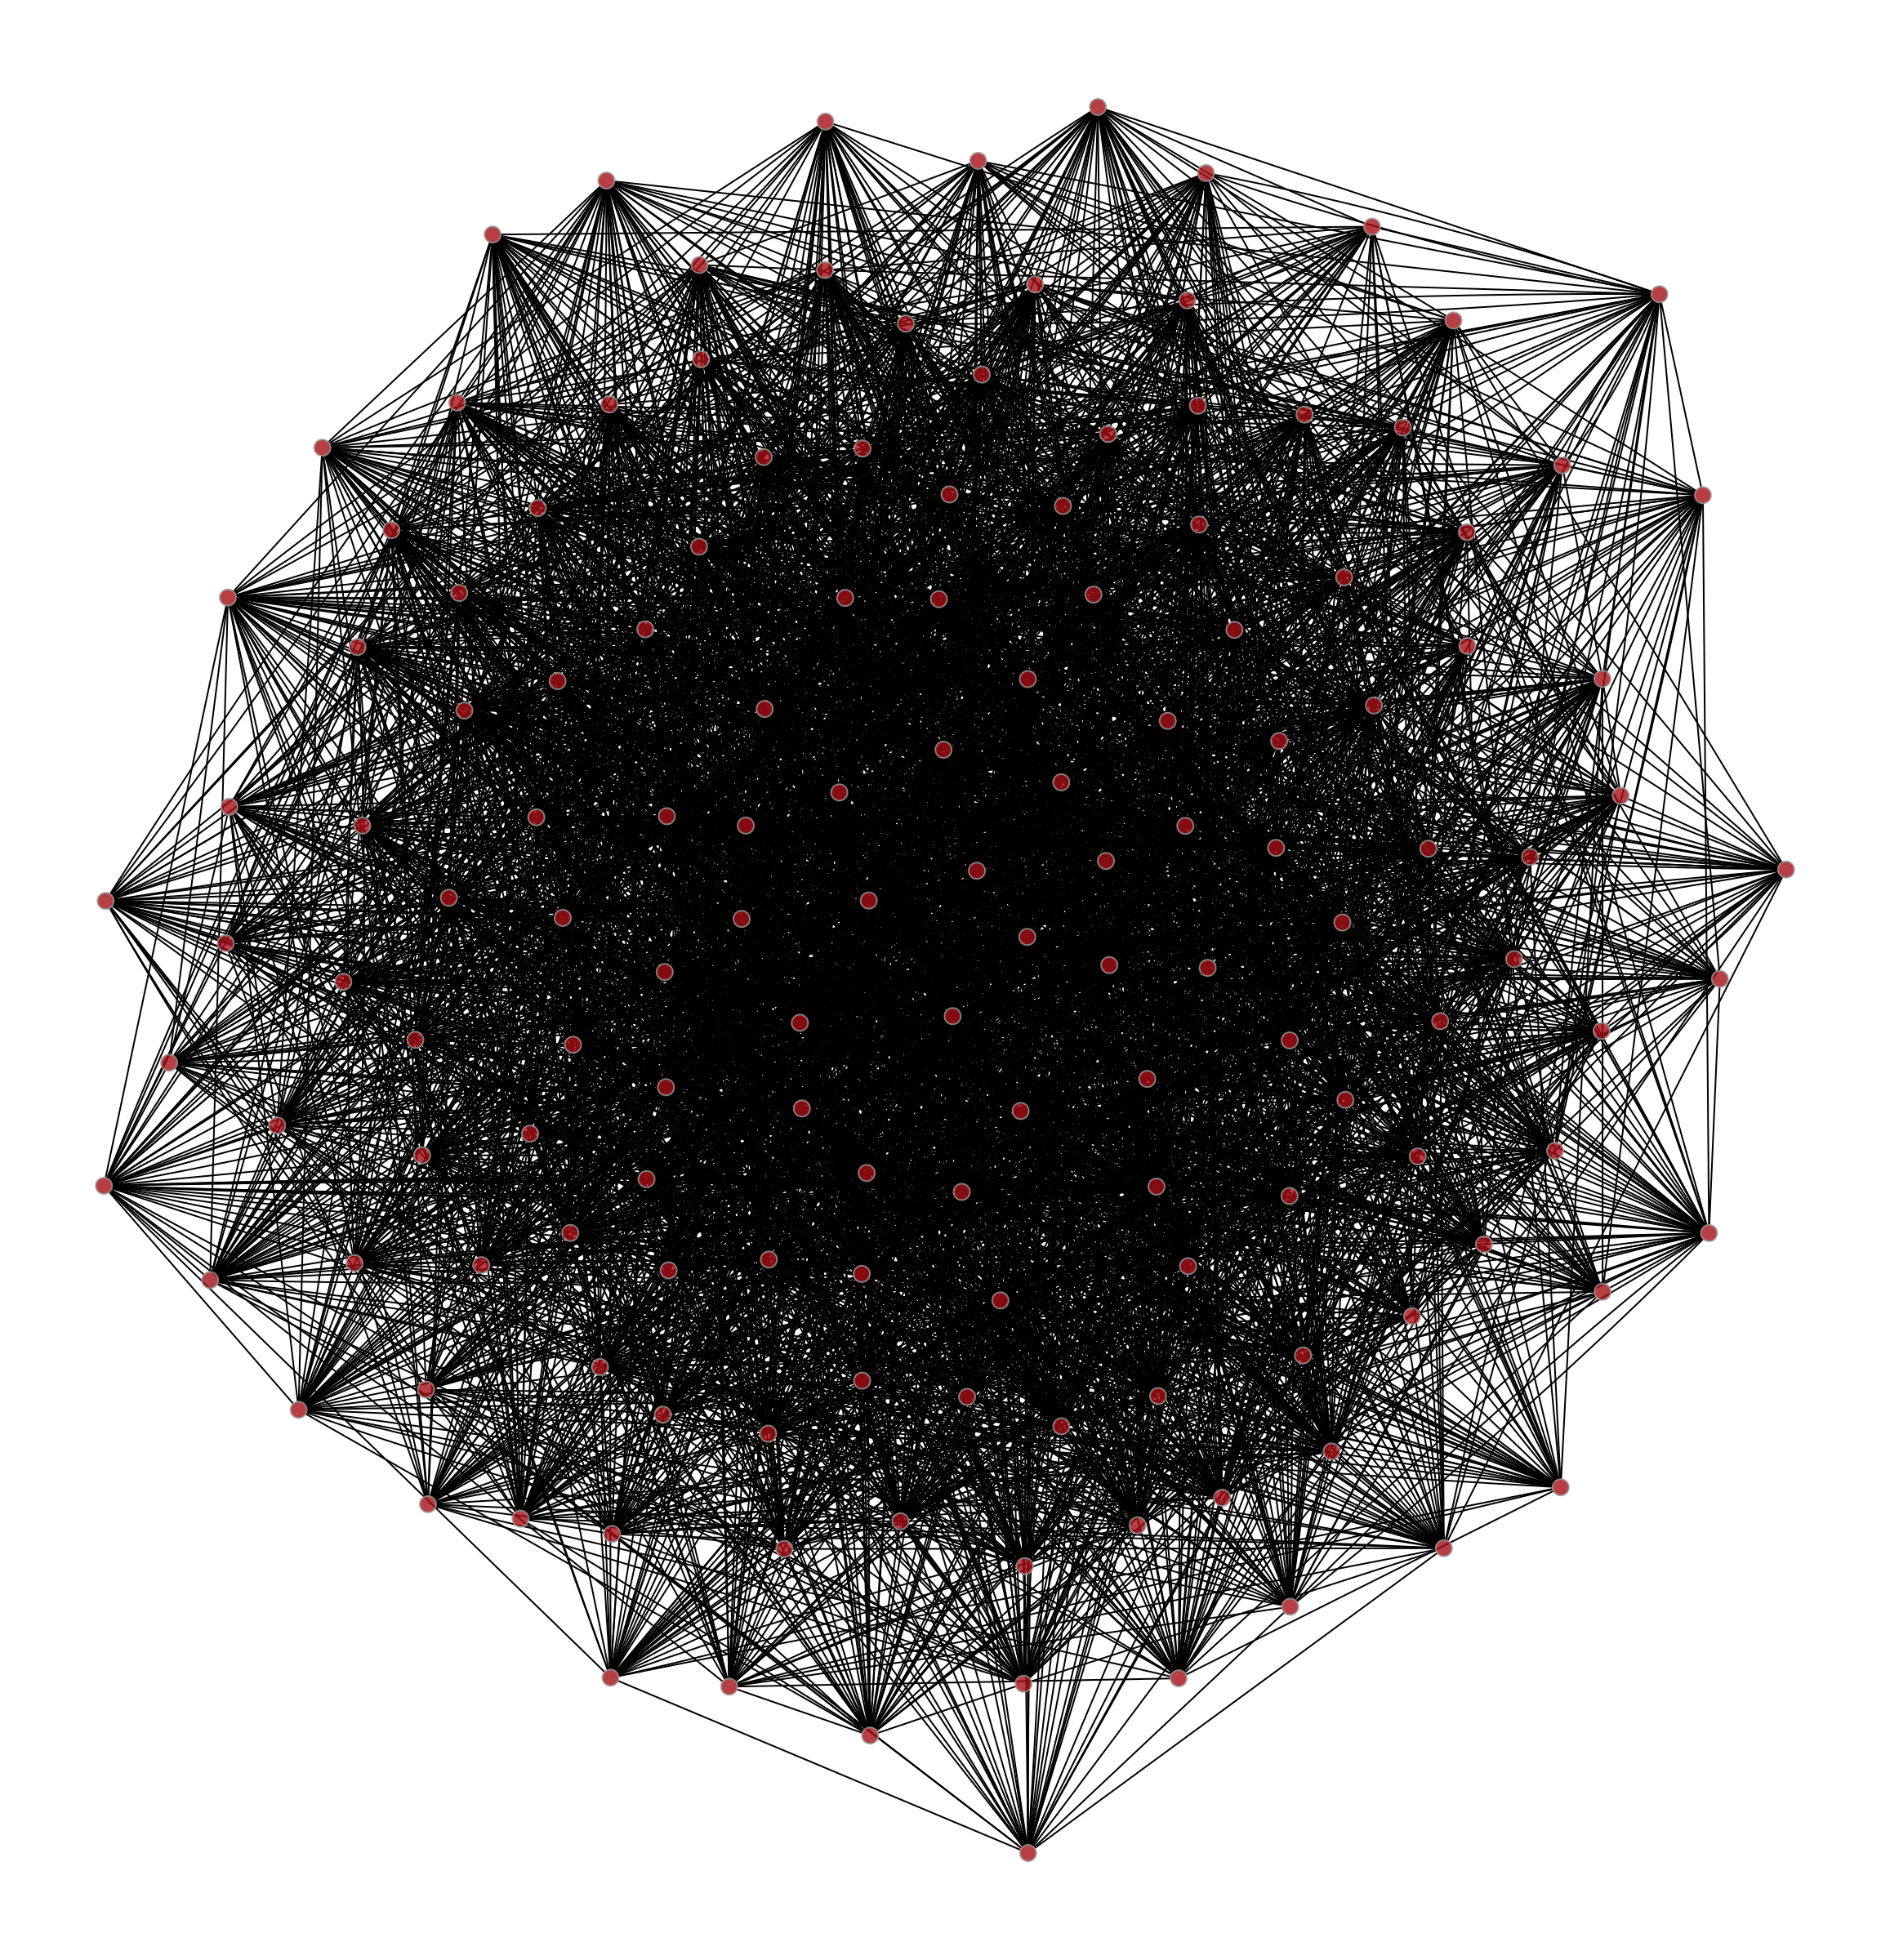

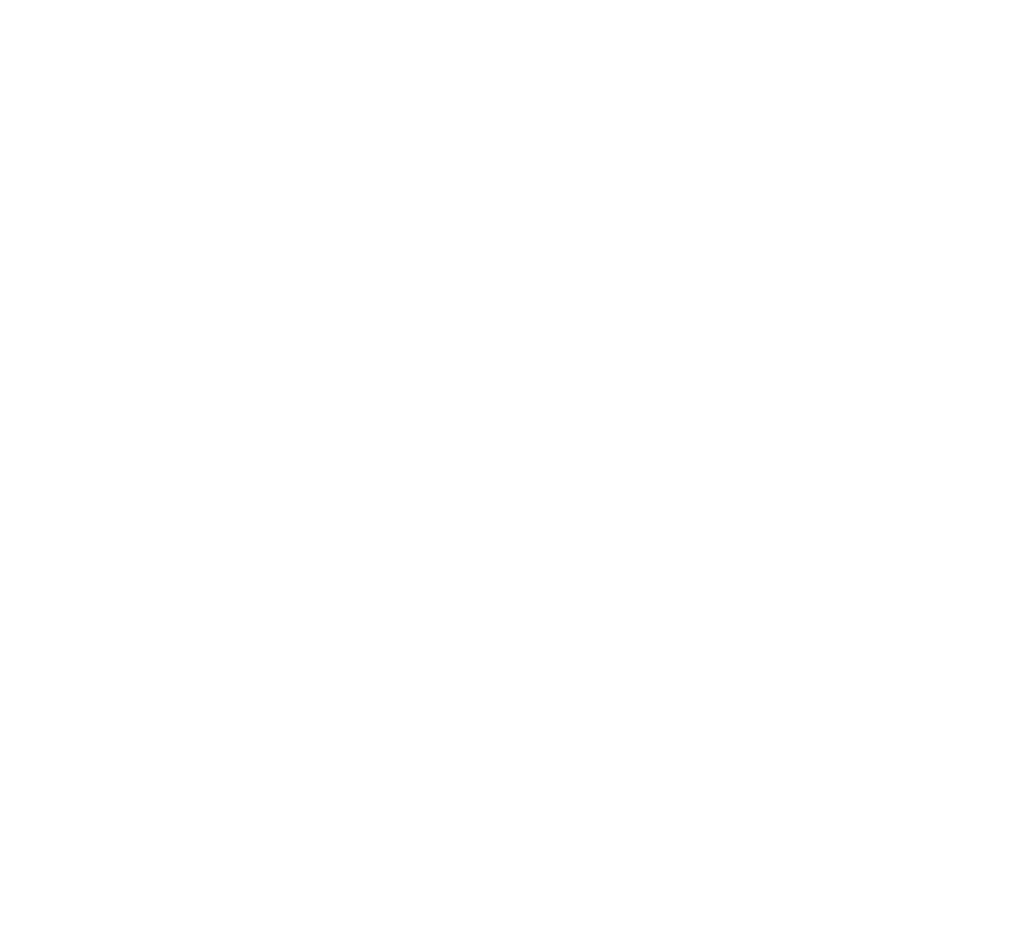

: 

In [16]:
data = {'source': ['STN', 'GPe', 'Cortex', 'Cortex', 'MSN_D1', 'MSN_D2', 'STN'],
        'target': ['GPe', 'STN', 'MSN_D1', 'MSN_D2', 'SNr', 'GPe', 'SNr'],
        'type': ['Excitatory', 'Inhibitory', 'Excitatory', 'Inhibitory', 'Excitatory', 'Inhibitory', 'Excitatory'],
        'Education Level': [1, 2, 3, 2, 1, 3, 2]}  

neuron_counts = {
    'STN': 30,
    'GPe_TA': 17,
    'GPe_TI': 17,
    'Cortex': 8,
    'MSN_D1': 30,
    'MSN_D2': 20,
    'SNr': 15,
    'FSN': 10
}

df = pd.DataFrame(data)

g = Graph(directed=False)  
node_map = {} 

for neuron, count in neuron_counts.items():
    for _ in range(count): 
        v = g.add_vertex()
        node_map[v] = neuron 

connection_probability = 0.2

for src in neuron_counts.keys():
    src_vertices = [v for v in g.vertices() if node_map[v] == src]
    for src_vertex in src_vertices:
        for tgt in neuron_counts.keys():
            if src != tgt:  
                tgt_vertices = [v for v in g.vertices() if node_map[v] == tgt]
                for tgt_vertex in tgt_vertices:
                    if np.random.rand() < connection_probability:  
                        g.add_edge(src_vertex, tgt_vertex)

education_level = g.new_vertex_property("int")

for v in g.vertices():
    education_level[v] = 1 

g.vp['Education Level'] = education_level

groups = g.new_vertex_property("int")
for v in g.vertices():
    groups[v] = list(neuron_counts.keys()).index(node_map[v]) 

pos = sfdp_layout(g, groups=groups)
pos_array = pos.get_2d_array([0, 1])

g.vp['x'] = g.new_vertex_property("double")
g.vp['y'] = g.new_vertex_property("double")

for v in g.vertices():
    g.vp['x'][v] = pos_array[0][int(v)]
    g.vp['y'][v] = pos_array[1][int(v)]

fig, ax = plt.subplots(figsize=(13, 12))

graph_draw(g, pos, vertex_size=10, edge_color='black', output_size=(1300, 1200), ax=ax)

ax.axis('off')
ax.set_xlim((g.vp['x'].a.min() - 1, g.vp['x'].a.max() + 1))
ax.set_ylim((g.vp['y'].a.min() - 1, g.vp['y'].a.max() + 1))

plt.show()

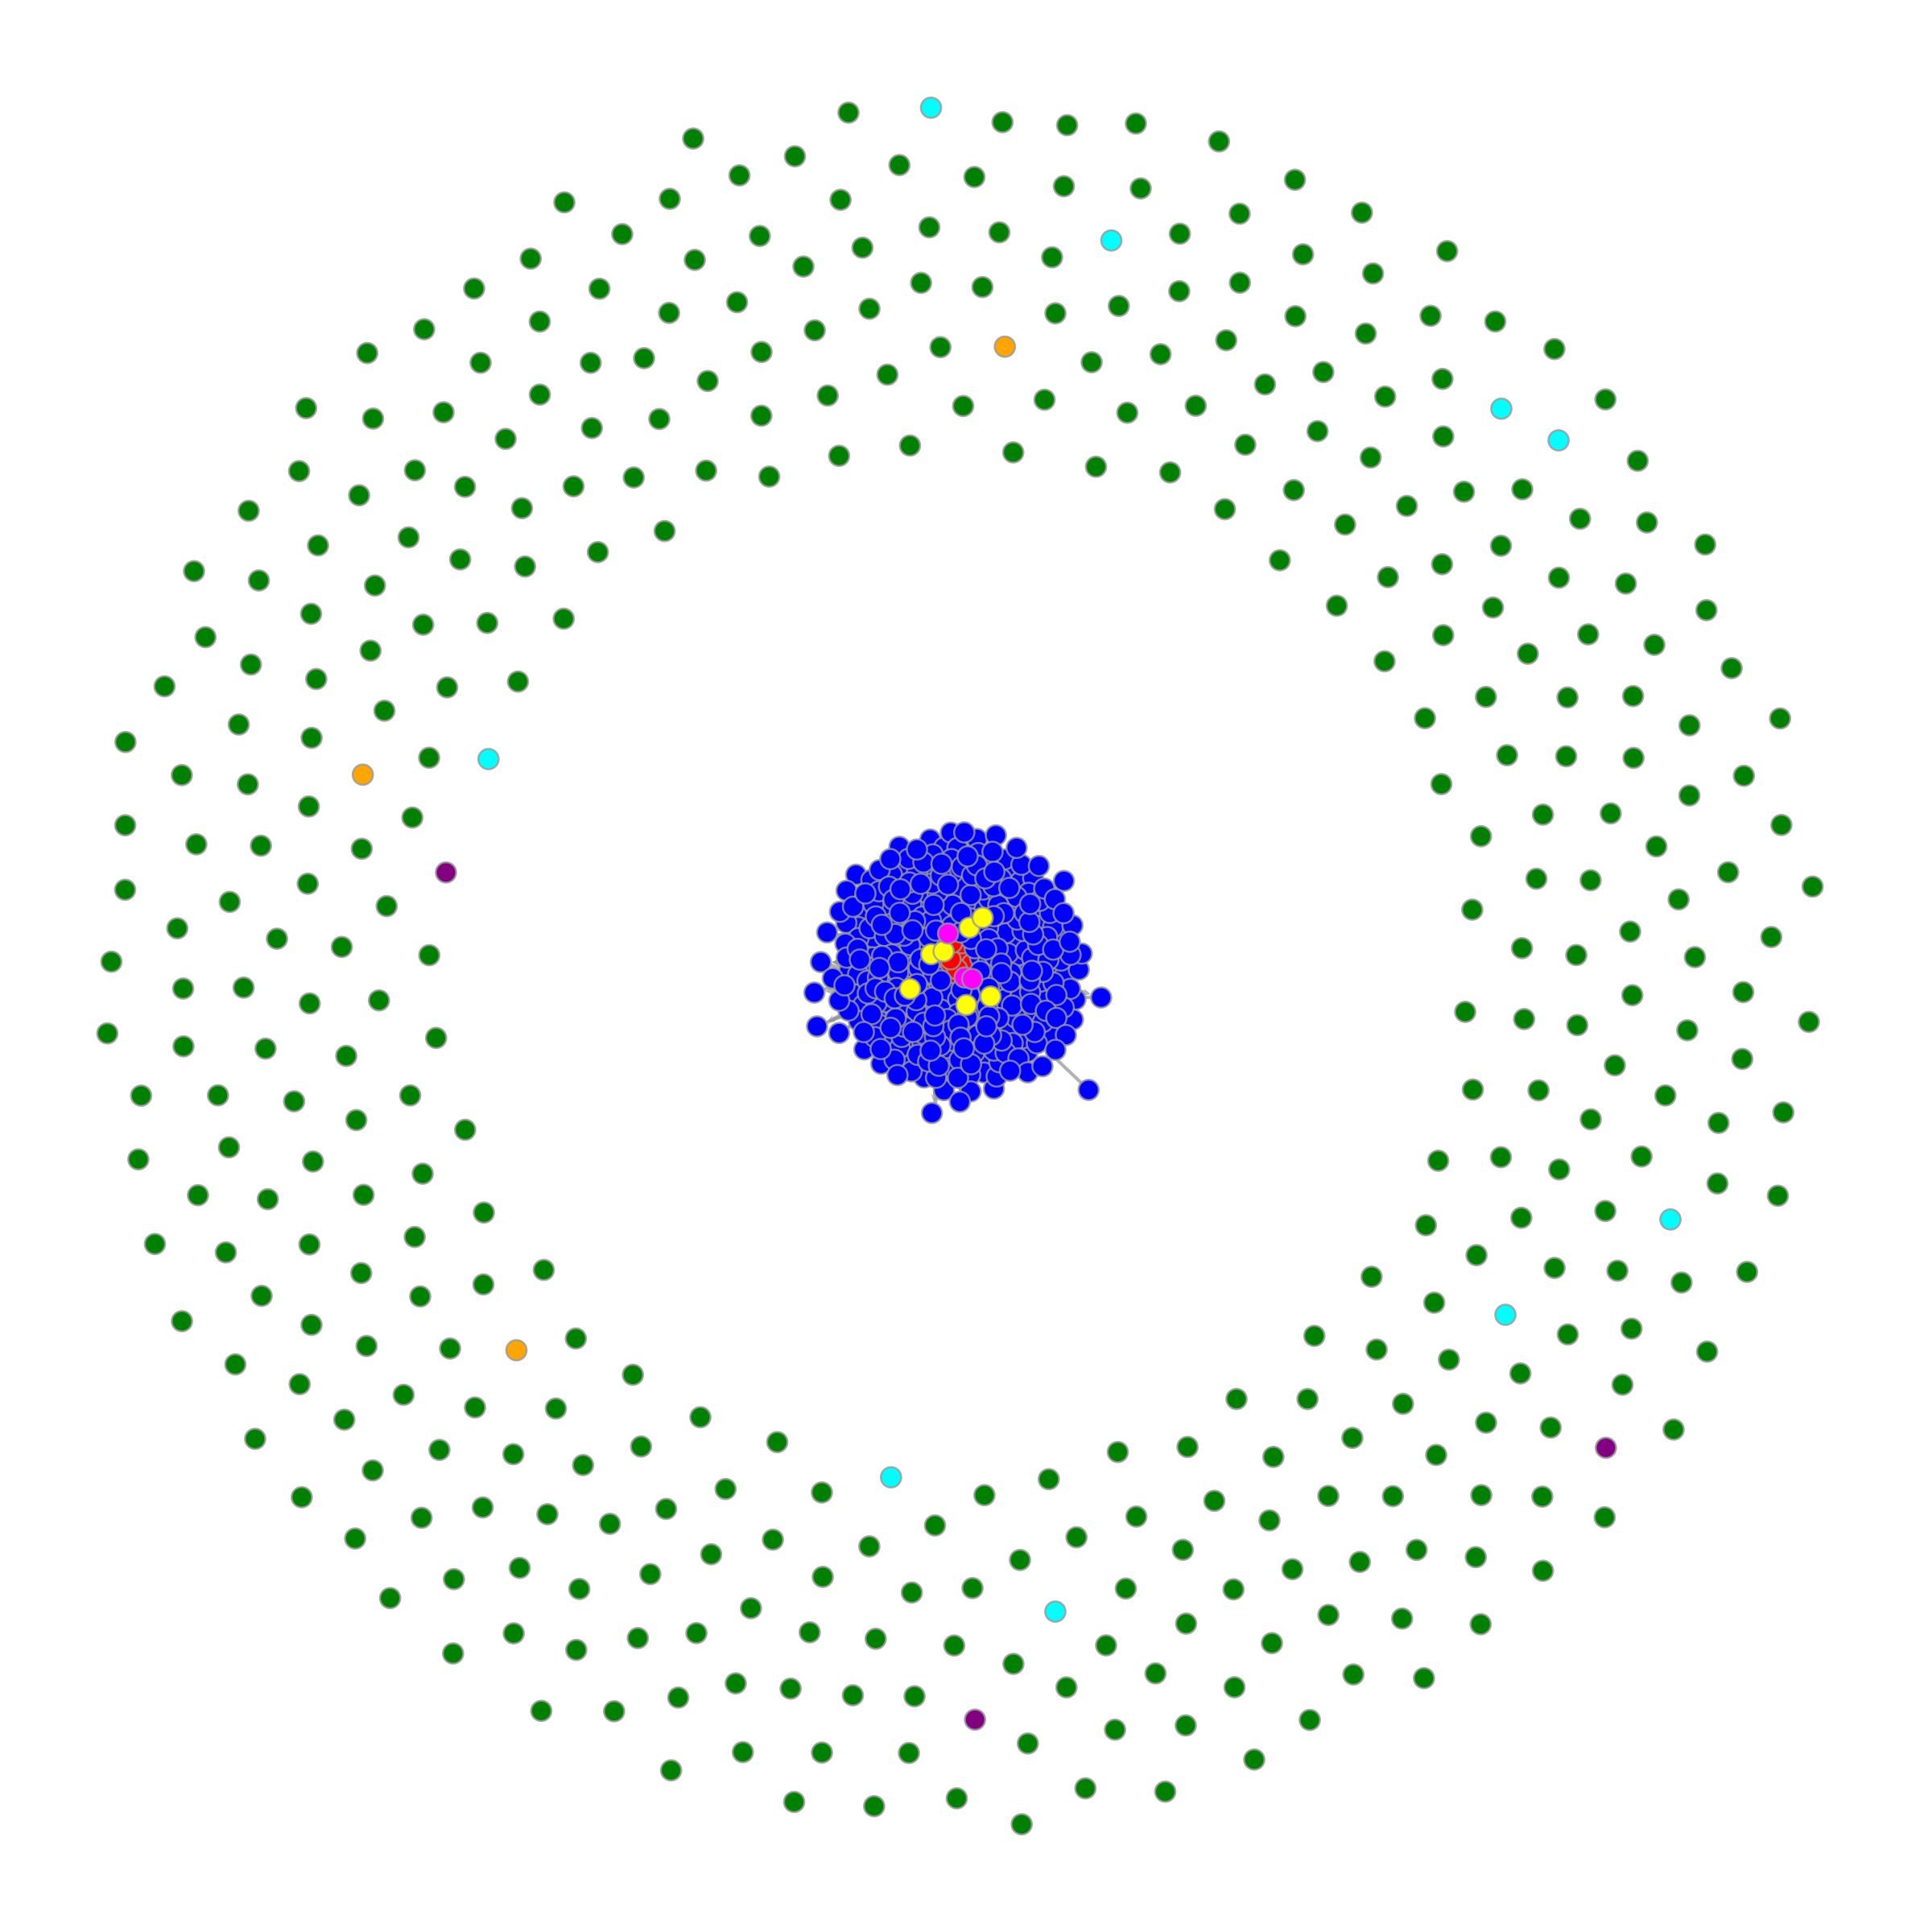

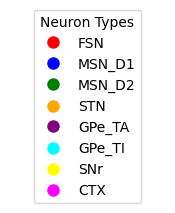

In [8]:
g = Graph(directed=True)
neuron_vertices = {}
vprop_color = g.new_vertex_property("vector<double>")
eprop_width = g.new_edge_property("double")
eprop_color = g.new_edge_property("vector<double>")

for neuron, count in neuron_counts.items():
    neuron_vertices[neuron] = [g.add_vertex() for _ in range(int(count / 100))]
    for v in neuron_vertices[neuron]:
        vprop_color[v] = mcolors.to_rgba(color_map[neuron])

for (src, tgt), prob in connection_probs.items():
    src_vertices = neuron_vertices[src]
    tgt_vertices = neuron_vertices[tgt]
    for src_vertex in src_vertices:
        connected_tgt_vertices = np.random.choice(tgt_vertices, int(len(tgt_vertices) * prob), replace=False)
        for tgt_vertex in connected_tgt_vertices:
            edge = g.add_edge(src_vertex, tgt_vertex)
            eprop_width[edge] = 1.5 + prob * 3
            eprop_color[edge] = mcolors.to_rgba('gray', alpha=0.6)

pos = sfdp_layout(g)

graph_draw(g, pos, vertex_fill_color=vprop_color, edge_pen_width=eprop_width, 
           edge_color=eprop_color, output_size=(1300, 1200), 
           edge_marker_size=5) 

fig, ax = plt.subplots(figsize=(2, 2))
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[neuron], 
                             markersize=10, label=neuron) for neuron in neuron_counts.keys()]
ax.legend(handles=legend_handles, loc='center', fontsize='medium', title="Neuron Types")
ax.axis('off')
plt.show()


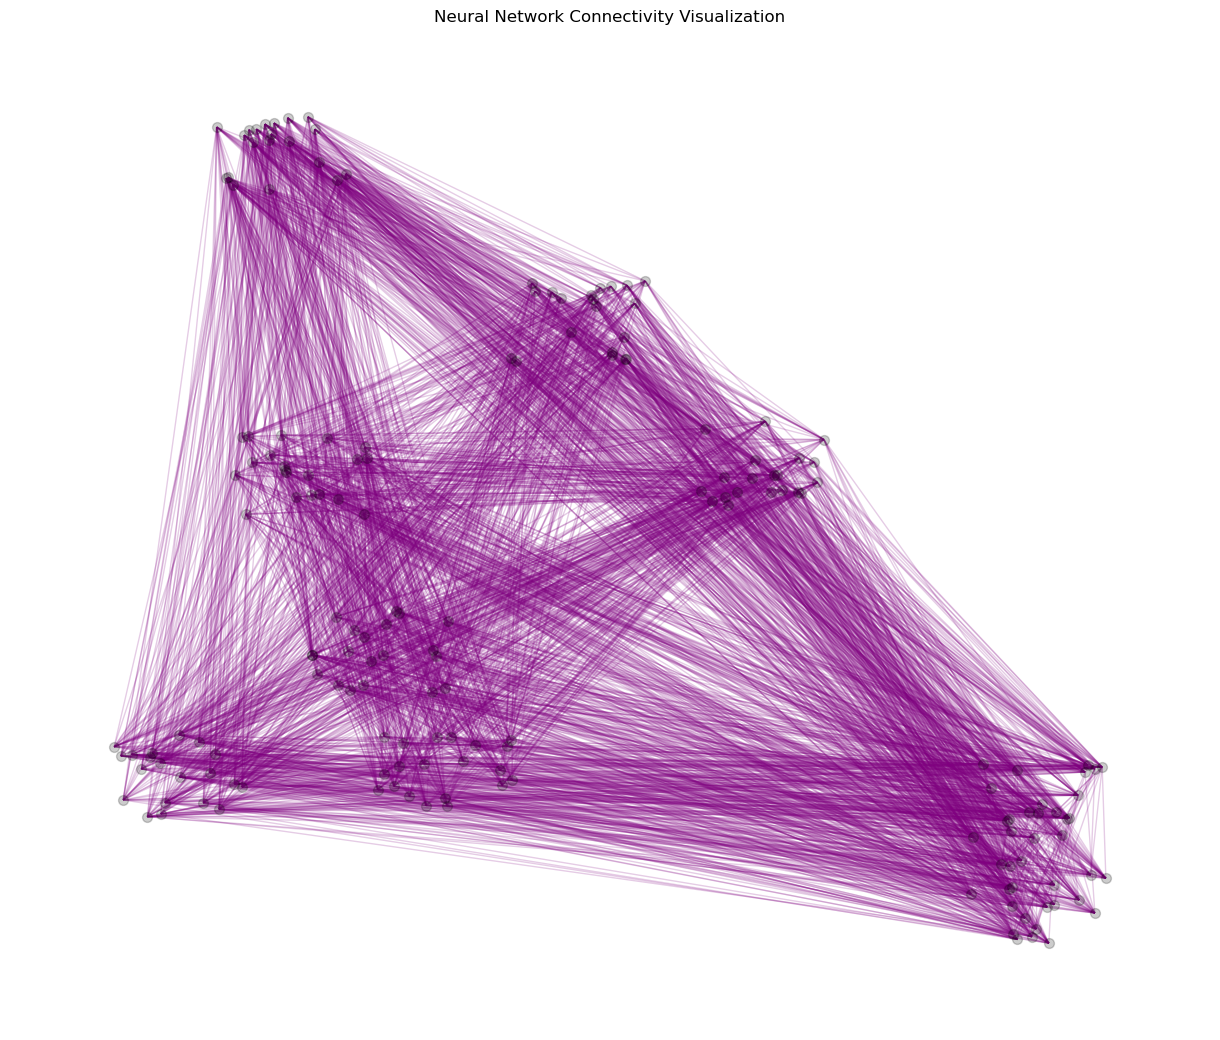

In [12]:
G = nx.Graph()

# create group & node
groups = {f"EL {i}": (random.uniform(0, 10), random.uniform(0, 10)) for i in range(9)}

positions = {}
node_size_per_group = 20
for group, (x, y) in groups.items():
    for i in range(node_size_per_group):
        node_name = f"{group}_{i}"
        G.add_node(node_name, group=group)
        positions[node_name] = (x + random.uniform(-0.5, 0.5), y + random.uniform(-0.5, 0.5))

for group1 in groups:
    for group2 in groups:
        if group1 != group2:
            nodes1 = [n for n in G.nodes if n.startswith(group1)]
            nodes2 = [n for n in G.nodes if n.startswith(group2)]
            for node1 in nodes1:
                for node2 in nodes2:
                    if random.random() < 0.1:  
                        G.add_edge(node1, node2, weight=random.random())

plt.figure(figsize=(12, 10))
nx.draw(G, pos=positions, with_labels=False,
        node_size=50, node_color='black',
        edge_color='purple', alpha=0.2)
plt.title("Neural Network Connectivity Visualization")
plt.show()


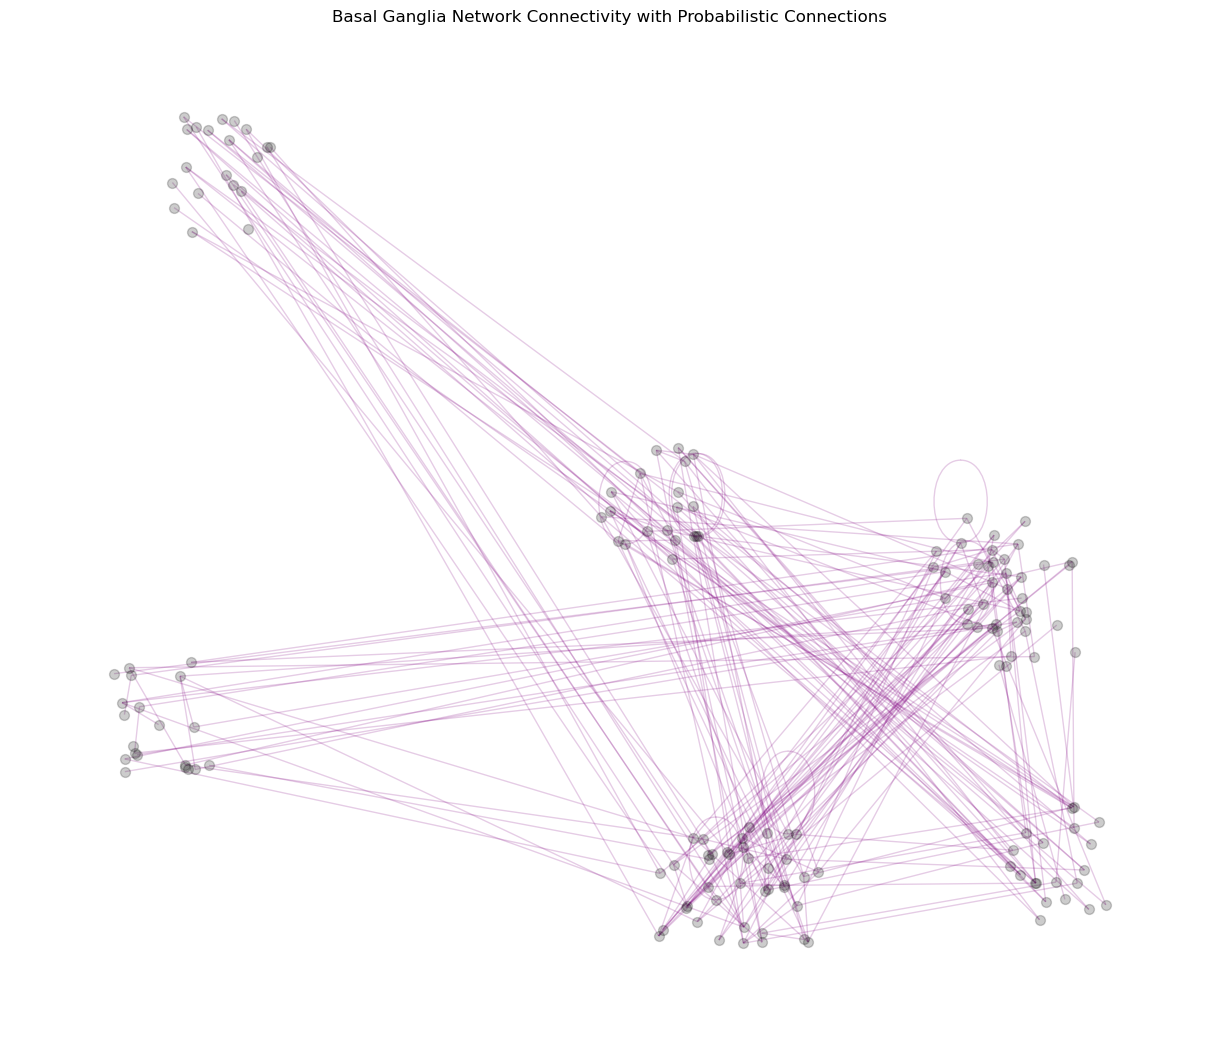

In [17]:
G = nx.Graph()

groups = {
    "FSN": (random.uniform(0, 10), random.uniform(0, 10)),
    "MSND1": (random.uniform(0, 10), random.uniform(0, 10)),
    "MSND2": (random.uniform(0, 10), random.uniform(0, 10)),
    "GPeT1": (random.uniform(0, 10), random.uniform(0, 10)),
    "GPeTA": (random.uniform(0, 10), random.uniform(0, 10)),
    "STN": (random.uniform(0, 10), random.uniform(0, 10)),
    "SNr": (random.uniform(0, 10), random.uniform(0, 10)),
    "CTX": (random.uniform(0, 10), random.uniform(0, 10)),
}

positions = {}
node_size_per_group = 20  
for group, (x, y) in groups.items():
    for i in range(node_size_per_group):
        node_name = f"{group}_{i}"
        G.add_node(node_name, group=group)
        positions[node_name] = (x + random.uniform(-0.5, 0.5), y + random.uniform(-0.5, 0.5))

connection_probabilities = {
    ('CTX', 'FSN'): 0.5,
    ('CTX', 'MSND1'): 0.5,
    ('CTX', 'MSND2'): 0.5,
    ('CTX', 'STN'): 0.5,
    ('FSN', 'MSND1'): 0.3,  
    ('FSN', 'MSND2'): 0.3, 
    ('FSN', 'FSN'): 0.3,  
    ('MSND1', 'MSND1'): 0.5,  
    ('MSND1', 'MSND2'): 0.5, 
    ('MSND1', 'SNr'): 0.5, 
    ('MSND2', 'MSND1'): 0.5, 
    ('MSND2', 'MSND2'): 0.5, 
    ('MSND2', 'GPeT1'): 0.5, 
    ('GPeT1', 'GPeT1'): 0.5, 
    ('GPeT1', 'GPeTA'): 0.5,
    ('GPeT1', 'SNr'): 0.5,
    ('GPeT1', 'STN'): 0.5,
    ('GPeTA', 'GPeTA'): 0.5,
    ('GPeTA', 'GPeT1'): 0.5,
    ('GPeTA', 'MSND1'): 0.5,
    ('GPeTA', 'MSND2'): 0.5, 
    ('STN', 'GPeT1'): 0.5, 
    ('STN', 'GPeTA'): 0.5, 
    ('STN', 'SNr'): 0.5, 
}

for (group1, group2), prob in connection_probabilities.items():
    nodes1 = [n for n in G.nodes if n.startswith(group1)]
    nodes2 = [n for n in G.nodes if n.startswith(group2)]
    
    num_connections = int(len(nodes1) * prob)
    
    selected_nodes1 = random.sample(nodes1, num_connections)
    selected_nodes2 = random.sample(nodes2, num_connections)
    
    for node1, node2 in zip(selected_nodes1, selected_nodes2):
        G.add_edge(node1, node2, weight=random.random())

plt.figure(figsize=(12, 10))
nx.draw(G, pos=positions, with_labels=False,
        node_size=50, node_color='black',
        edge_color='purple', alpha=0.2)
plt.show()


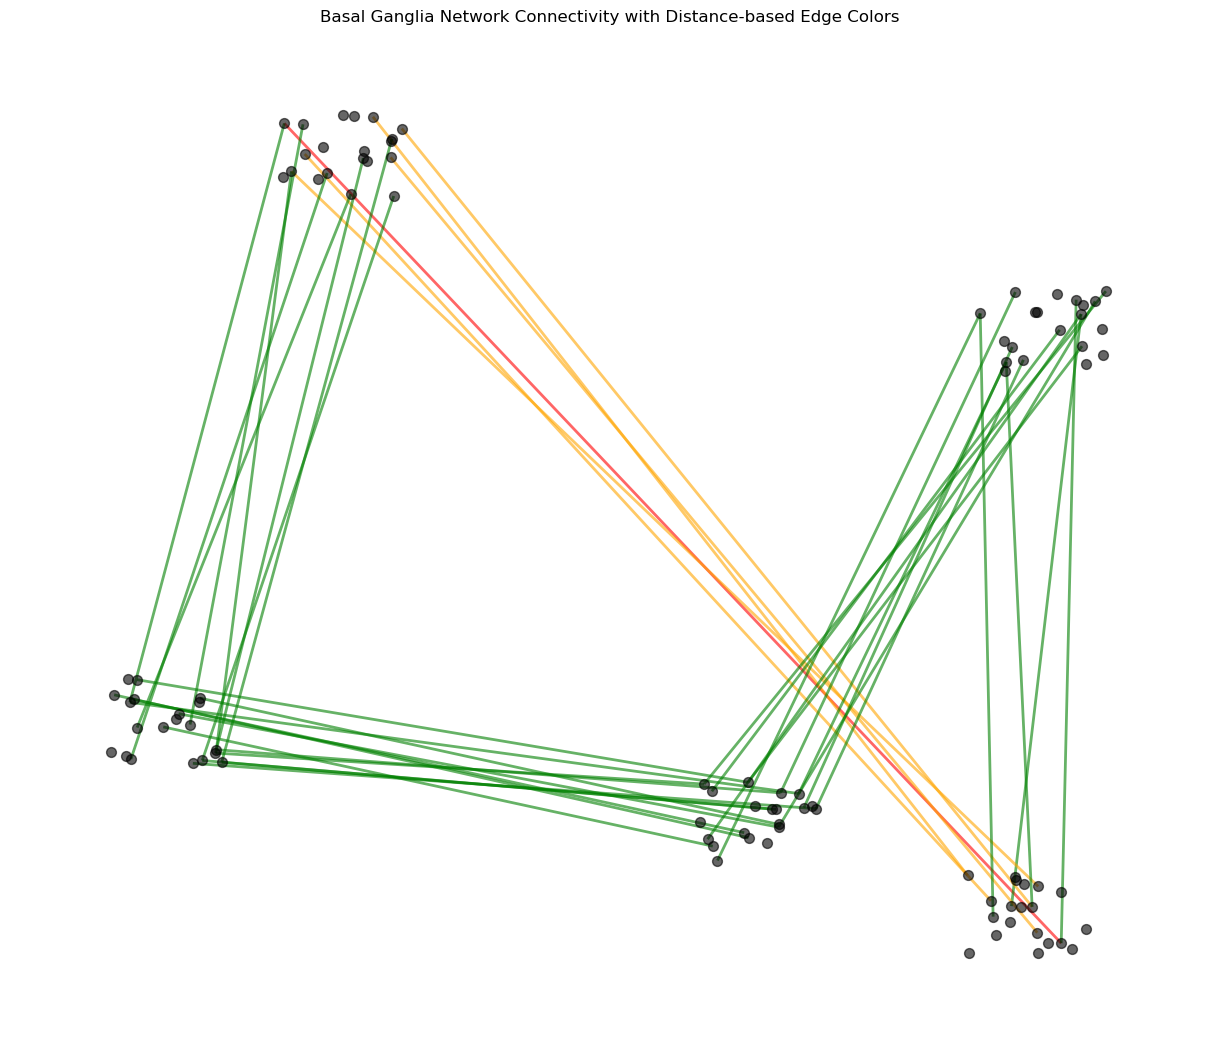

In [18]:
G = nx.Graph()

groups = {
    "STN": (random.uniform(0, 10), random.uniform(0, 10)),
    "GPe": (random.uniform(0, 10), random.uniform(0, 10)),
    "Striatum": (random.uniform(0, 10), random.uniform(0, 10)),
    "GPi": (random.uniform(0, 10), random.uniform(0, 10)),
    "Cortex": (random.uniform(0, 10), random.uniform(0, 10)),
}

positions = {}
node_size_per_group = 20 
for group, (x, y) in groups.items():
    for i in range(node_size_per_group):
        node_name = f"{group}_{i}"
        G.add_node(node_name, group=group)
        positions[node_name] = (x + random.uniform(-0.5, 0.5), y + random.uniform(-0.5, 0.5))

connection_probabilities = {
    ('STN', 'GPe'): 0.3,  
    ('Cortex', 'Striatum'): 0.5,  
    ('Striatum', 'GPi'): 0.6, 
    ('GPe', 'GPi'): 0.4,  
    ('Cortex', 'STN'): 0.2,  
}

for (group1, group2), prob in connection_probabilities.items():
    nodes1 = [n for n in G.nodes if n.startswith(group1)]
    nodes2 = [n for n in G.nodes if n.startswith(group2)]
    
    num_connections = int(len(nodes1) * prob) 
    
    selected_nodes1 = random.sample(nodes1, num_connections)
    selected_nodes2 = random.sample(nodes2, num_connections)
    
    for node1, node2 in zip(selected_nodes1, selected_nodes2):
        G.add_edge(node1, node2, weight=random.random())

edges = G.edges()
edge_colors = []
distances = []

def calculate_distance(node1, node2):
    x1, y1 = positions[node1]
    x2, y2 = positions[node2]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

for edge in edges:
    distance = calculate_distance(edge[0], edge[1])
    distances.append(distance)

min_distance = min(distances)
max_distance = max(distances)
mid_distance = (max_distance - min_distance) / 2 + min_distance

for distance in distances:
    if distance < mid_distance:
        edge_colors.append('green')  
    elif distance > mid_distance and distance < max_distance:
        edge_colors.append('orange')  
    else:
        edge_colors.append('red')  

plt.figure(figsize=(12, 10))
nx.draw(G, pos=positions, with_labels=False,
        node_size=50, node_color='black',
        edge_color=edge_colors, alpha=0.6, width=2)
plt.show()


/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/ipykernel_11539/3076796181.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


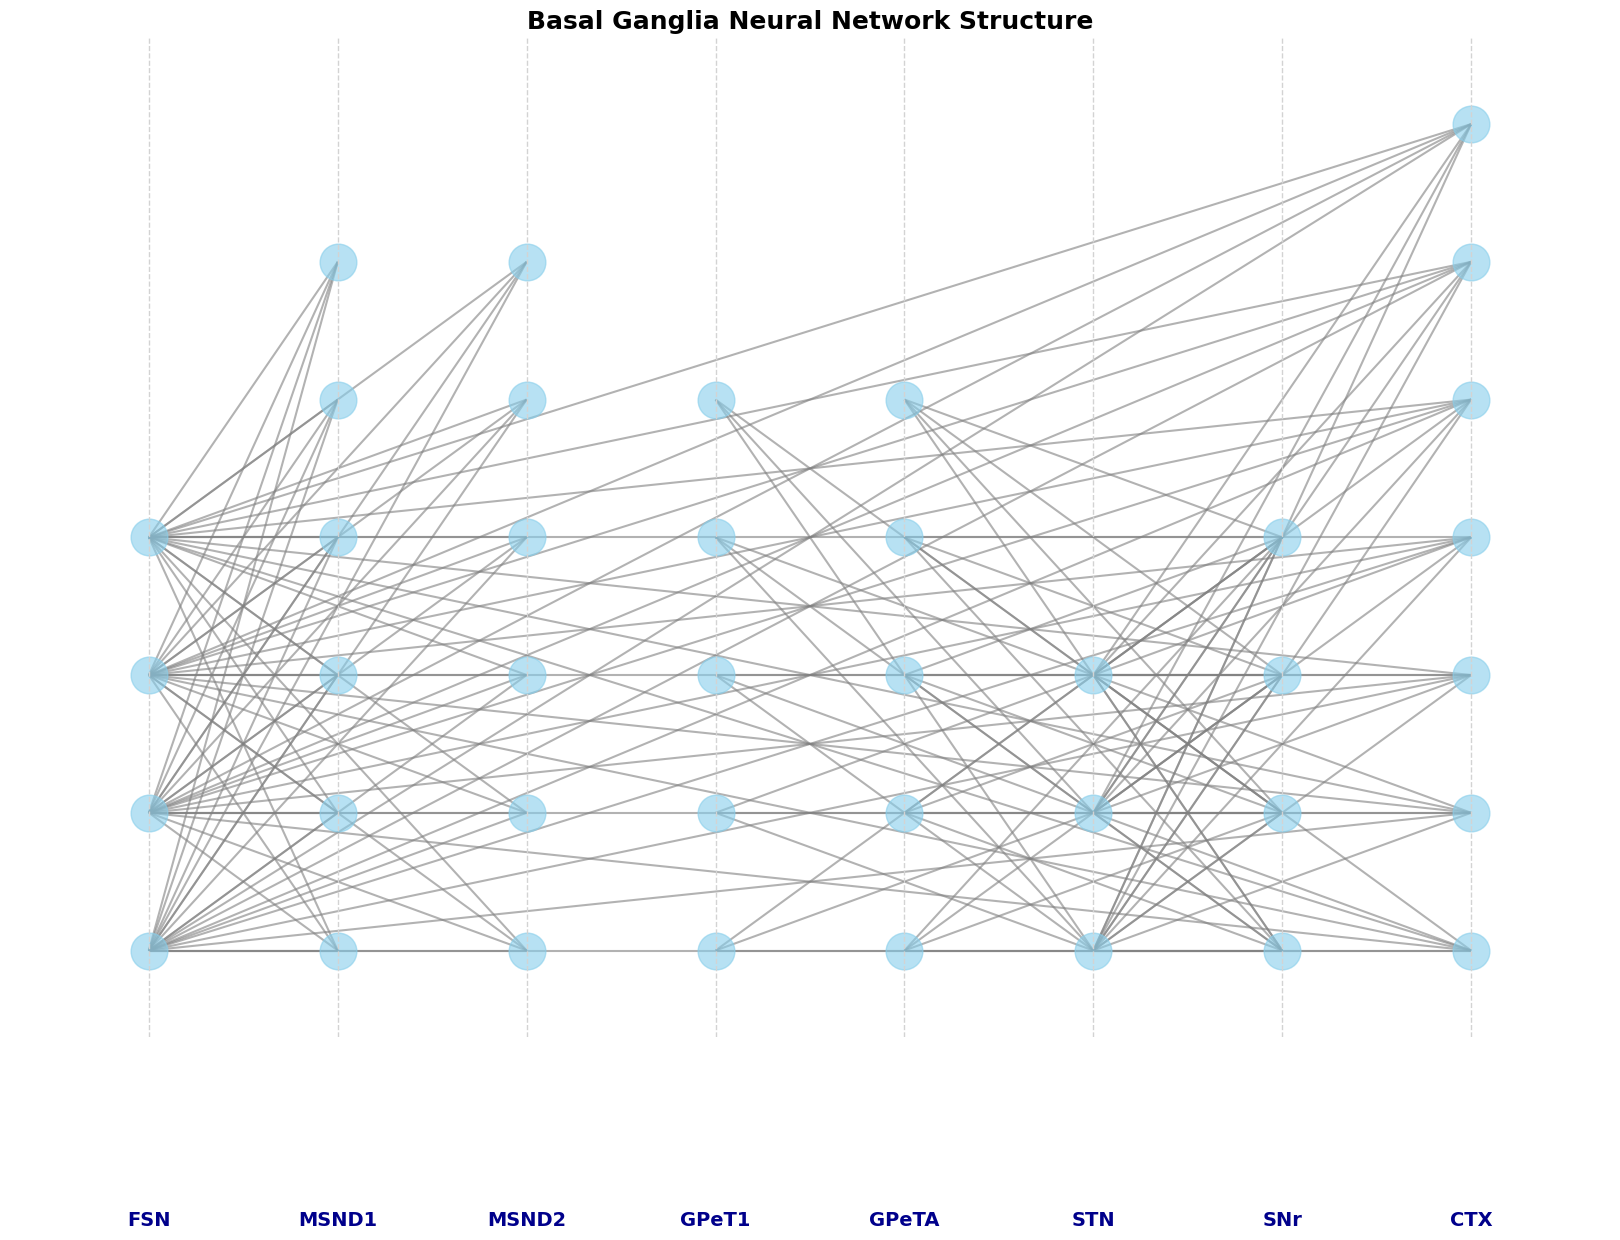

In [6]:
G = nx.Graph()

layers = {
    "FSN": 4,
    "MSND1": 6,
    "MSND2": 6,
    "GPeT1": 5,
    "GPeTA": 5,
    "STN": 3,
    "SNr": 4,
    "CTX": 7
}

connections = [
    ("FSN", "MSND1"), ("FSN", "MSND2"),
    ("CTX", "FSN"), ("CTX", "STN"),
    ("STN", "SNr"),
    ("GPeT1", "STN"), ("GPeTA", "SNr"),
]

# set params
positions = {}
layer_gap = 5  
neuron_gap = 1.5  
layer_centers = {}  

layer_index = 0
for group, num_neurons in layers.items():
    y_positions = []
    for neuron_idx in range(num_neurons):
        node_name = f"{group}_{neuron_idx}"
        G.add_node(node_name)
        x_pos = layer_index * layer_gap
        y_pos = neuron_idx * neuron_gap
        positions[node_name] = (x_pos, y_pos)
        y_positions.append(y_pos)
    layer_centers[group] = (x_pos, sum(y_positions) / len(y_positions))
    layer_index += 1

for conn in connections:
    group1_nodes = [n for n in G.nodes if n.startswith(conn[0])]
    group2_nodes = [n for n in G.nodes if n.startswith(conn[1])]
    for node1 in group1_nodes:
        for node2 in group2_nodes:
            G.add_edge(node1, node2)

# visualization
plt.figure(figsize=(16, 10))
nx.draw(G, pos=positions, with_labels=False,
        node_size=700, node_color='skyblue',  
        edge_color='gray', width=1.5, alpha=0.6)  

for idx, (group, (x, _)) in enumerate(layer_centers.items()):
    plt.axvline(x=x, color='lightgray', linestyle='--', linewidth=1)
    plt.text(x, -3, group, fontsize=14, ha='center', fontweight='bold', color='darkblue')

plt.axis('off')  
plt.tight_layout()
plt.show()

/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/ipykernel_11539/1988113705.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


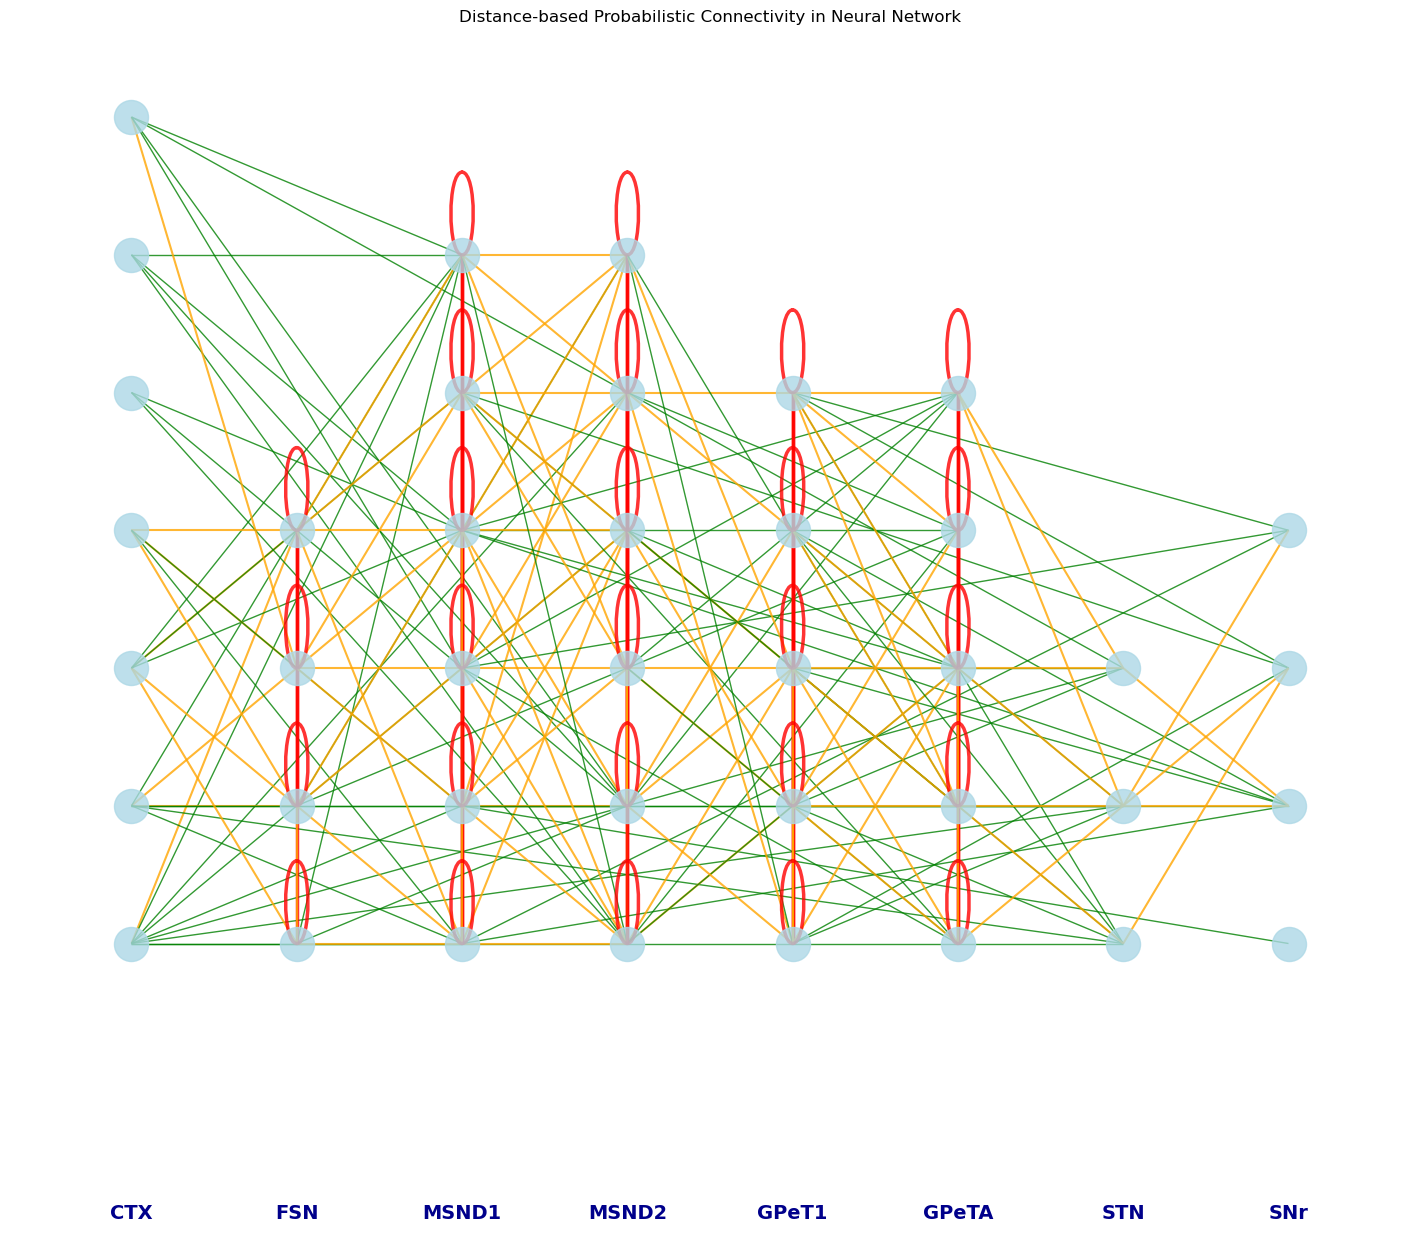

In [12]:
G = nx.Graph()

layers = {
    "CTX": 7,
    "FSN": 4,
    "MSND1": 6,
    "MSND2": 6,
    "GPeT1": 5,
    "GPeTA": 5,
    "STN": 3,
    "SNr": 4
}

connections = {
    ('CTX', 'FSN'),
    ('CTX', 'MSND1'),
    ('CTX', 'MSND2'),
    ('CTX', 'STN'),
    ('FSN', 'MSND1'),  
    ('FSN', 'MSND2'), 
    ('FSN', 'FSN'),  
    ('MSND1', 'MSND1'),  
    ('MSND1', 'MSND2'), 
    ('MSND1', 'SNr'), 
    ('MSND2', 'MSND1'), 
    ('MSND2', 'MSND2'), 
    ('MSND2', 'GPeT1'), 
    ('GPeT1', 'GPeT1'), 
    ('GPeT1', 'GPeTA'),
    ('GPeT1', 'SNr'),
    ('GPeT1', 'STN'),
    ('GPeTA', 'GPeTA'),
    ('GPeTA', 'GPeT1'),
    ('GPeTA', 'MSND1'),
    ('GPeTA', 'MSND2'), 
    ('STN', 'GPeT1'), 
    ('STN', 'GPeTA'), 
    ('STN', 'SNr') 
}

positions = {}
layer_gap = 5
neuron_gap = 1.5

layer_index = 0
for group, num_neurons in layers.items():
    for neuron_idx in range(num_neurons):
        node_name = f"{group}_{neuron_idx}"
        G.add_node(node_name)
        x_pos = layer_index * layer_gap
        y_pos = neuron_idx * neuron_gap
        positions[node_name] = (x_pos, y_pos)
    layer_index += 1

def calculate_distance(pos1, pos2):
    return np.sqrt((pos2[0] - pos1[0]) ** 2 + (pos2[1] - pos1[1]) ** 2)

def get_edge_color_and_width(distance):
    if distance < 4:
        return 'red', 2.5
    elif distance < 8:
        return 'orange', 1.5 
    else:
        return 'green', 1.0 

# connect based on distance 
for conn in connections:
    group1_nodes = [n for n in G.nodes if n.startswith(conn[0])]
    group2_nodes = [n for n in G.nodes if n.startswith(conn[1])]
    for node1 in group1_nodes:
        for node2 in group2_nodes:
            distance = calculate_distance(positions[node1], positions[node2])
            connection_probability = max(0.3, 1 - distance / 10)  
            if random.random() < connection_probability:
                color, width = get_edge_color_and_width(distance)
                G.add_edge(node1, node2, color=color, width=width)  

plt.figure(figsize=(14, 10))

edges = G.edges()
edge_colors = [G[u][v]['color'] for u, v in edges]
edge_widths = [G[u][v]['width'] for u, v in edges]

nx.draw(G, pos=positions, with_labels=False,
        node_size=600, node_color='lightblue',
        edge_color=edge_colors, width=edge_widths, alpha=0.8)

for idx, (group, num_neurons) in enumerate(layers.items()):
    x = idx * layer_gap
    plt.text(x, -3, group, fontsize=14, ha='center', fontweight='bold', color='darkblue')

plt.axis('off')
plt.tight_layout()
plt.show()